## RUL prediction using 1D CNN and SVR 



In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models 
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


2023-02-08 15:15:19.400242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 15:15:20.179156: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 15:15:20.251041: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 15:15:20.251417: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow Version:  2.11.0
Numpy version:  1.23.4
Pandas version:  1.5.1
Scikit-learn version:  1.1.3


In [3]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [4]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
   
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [5]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

# Data preprocessing

In [7]:
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]
train_data=pd.read_csv("../data/train_FD001.txt", sep= "\s+", header = None,names=columns)   
test_data =pd.read_csv("../data/test_FD001.txt", sep= "\s+", header = None,names=columns) 
true_rul = pd.read_csv("../data/RUL_FD001.txt", sep= "\s+", header = None) 

window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped =['id','op1','op2','op3', 'sensor1', 'sensor5', 'sensor6','sensor7','sensor10',
                 'sensor16', 'sensor18', 'sensor19']

train_data_first_column = train_data['id']
test_data_first_column = test_data['id']

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))

train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


/tmp/ipykernel_5857/3332817633.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
/tmp/ipykernel_5857/3332817633.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

## Training and validation split

We will take 20% of training data (sampled randomly) as our validation set

In [8]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


# CNN+SVR

In [10]:
cnn3=models.Sequential([
    #layers.Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])),
    layers.Conv1D(filters=32,kernel_size=3,activation='relu', input_shape=(window_length, processed_train_data.shape[2])),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(filters=64,kernel_size=3,activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(filters=32,kernel_size=3,activation='relu'),
    layers.MaxPooling1D(2),
    
     layers.Flatten(),
     # dense
     layers.Dense(1)
     
    ])
    
cnn3.compile(optimizer='adam',loss='mean_squared_error')   

In [11]:
cnn3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 28, 32)            1376      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 12, 64)            6208      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 4, 32)             6176      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 32)           

In [12]:
history2 = cnn3.fit(processed_train_data, processed_train_targets,
                    validation_data=(processed_val_data, processed_val_targets),
                    epochs=20,
                   batch_size=64)

Epoch 1/20
222/222 [==============================] - 2s 7ms/step - loss: 1725.9745 - val_loss: 415.0757
Epoch 2/20
222/222 [==============================] - 1s 6ms/step - loss: 391.2129 - val_loss: 324.4677
Epoch 3/20
222/222 [==============================] - 1s 6ms/step - loss: 315.2551 - val_loss: 263.9727
Epoch 4/20
222/222 [==============================] - 1s 6ms/step - loss: 269.4103 - val_loss: 240.3194
Epoch 5/20
222/222 [==============================] - 1s 6ms/step - loss: 249.5112 - val_loss: 229.5453
Epoch 6/20
222/222 [==============================] - 1s 6ms/step - loss: 236.2292 - val_loss: 228.1679
Epoch 7/20
222/222 [==============================] - 1s 6ms/step - loss: 229.2017 - val_loss: 213.1644
Epoch 8/20
222/222 [==============================] - 1s 6ms/step - loss: 223.8891 - val_loss: 207.1324
Epoch 9/20
222/222 [==============================] - 1s 6ms/step - loss: 216.1218 - val_loss: 205.8729
Epoch 10/20
222/222 [==============================] - 1s 6ms/s

In [38]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

In [22]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [23]:

history = cnn3.fit(processed_train_data, processed_train_targets, epochs = 30,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
222/222 - 2s - loss: 1653.3618 - val_loss: 435.3081 - lr: 0.0010 - 2s/epoch - 11ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
222/222 - 1s - loss: 388.9934 - val_loss: 339.6838 - lr: 0.0010 - 1s/epoch - 6ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
222/222 - 1s - loss: 320.6234 - val_loss: 283.7435 - lr: 0.0010 - 1s/epoch - 6ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/20
222/222 - 1s - loss: 285.2183 - val_loss: 261.4735 - lr: 0.0010 - 1s/epoch - 6ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/20
222/222 - 1s - loss: 264.4384 - val_loss: 240.8700 - lr: 0.0010 - 1s/epoch - 6ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/20
222/222 - 1s - loss: 250.9825 - val_loss: 230.6599 - lr: 0.0010 - 1s/epoch - 7ms/step

Epoch 7: LearningRateScheduler 

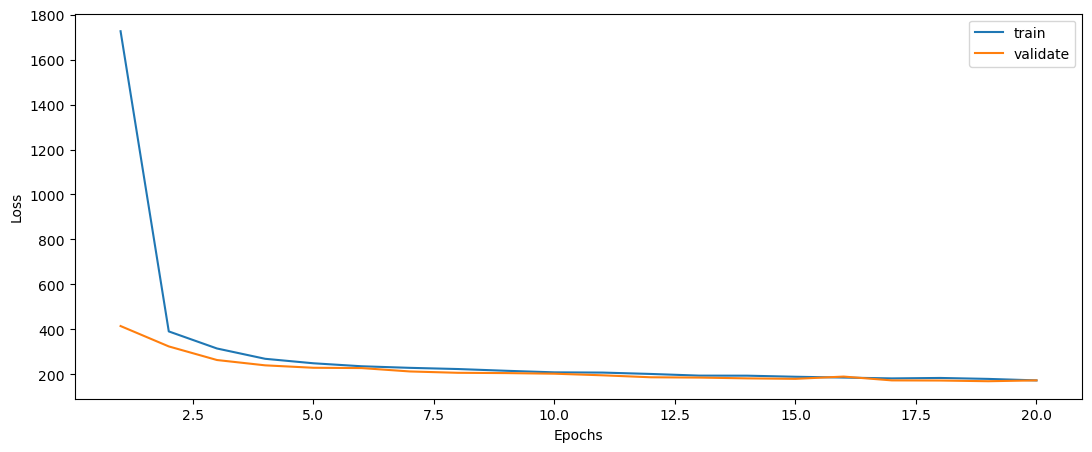

In [13]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history2)

In [15]:
train_3 = cnn3.predict(processed_train_data)

444/444 [==============================] - 1s 2ms/step


In [16]:
test_3 = cnn3.predict(processed_test_data)

16/16 [==============================] - 0s 3ms/step


In [17]:
array = processed_train_targets.reshape(-1,1)

In [18]:
best_reg_model =SVR()
best_reg_model.fit(train_3,array)

/home/safsaf/anaconda3/envs/sa/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [20]:
y_pred_test =best_reg_model.predict(test_3)

In [21]:
preds_for_each_engine = np.split(y_pred_test, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine,weights=np.repeat(1/num_windows, num_windows),axis=0)
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  16.072743746134076


In [22]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  15.921427261690363


For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where, 

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [25]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [26]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  502.2580267892828


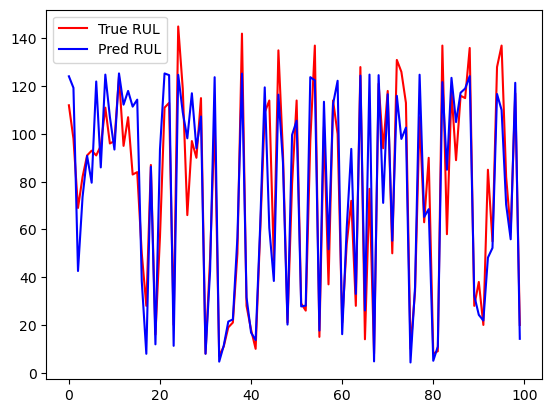

In [27]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()